# Libraries

In [ ]:
# if you use google colab, install the following libraries:
# !pip install emoji datasets contractions pyLDAvis fasttext -U ipykernel

In [2]:
import os
import re
import pickle
import string
from pprint import pprint
from math import sqrt, pow, exp

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

import emoji
import contractions
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
import pyLDAvis.gensim
import pyLDAvis

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import fasttext
from sklearn.manifold import TSNE

plt.style.use('seaborn-v0_8-pastel')

# Introduction

description here

# Load data set

In [3]:
# load data
df = pd.read_parquet('../data/raw/df_amazon_reviews_sample_5k.gzip')

# Text representation

## Pre-processing

In [4]:
# util function
def show_transformation(df, seed=18):
    with pd.option_context('display.max_colwidth', None):
        display(df[['review_body','review_body_preprocessed']].sample(1, random_state=seed))

In [5]:
# expand contractions
df['review_body_preprocessed']=df['review_body'].progress_apply(lambda x: contractions.fix(x))
show_transformation(df)

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.","I just finished this game after a long time playing it. I have not really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he is missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it is really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that is intentional). Everything works.<br />I cannot think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there. You cannot expect them to find their own way back in a cavern where there is lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You do not even have the money excuse, because it is so cheap. Buy it. Play it. And then realize that, as good as some of the other games you are playing are, there is something that tops even those."


In [6]:
# demojize texts
df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: emoji.demojize(x))
# look at a previous example
with pd.option_context('display.max_colwidth', None):
    display(df[df.index == 180063][['review_body','review_body_preprocessed']])

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
180063,I purchased this game for my baby 👶 boy and he plays it all day 👍👍👍👍👍👍,I purchased this game for my baby :baby: boy and he plays it all day :thumbs_up::thumbs_up::thumbs_up::thumbs_up::thumbs_up::thumbs_up:


In [7]:
# remove punctuation
string.punctuation
print(f'Punctuation list: {string.punctuation}')

def remove_punctuation(text):
    return ''.join([char for char in text if char not in string.punctuation])

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: remove_punctuation(x))
show_transformation(df)

Punctuation list: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",I just finished this game after a long time playing it I have not really played any RPGs before but I had heard good things about this game and it was at a bargain price so I said quotwhat the heckquotbr What a lucky lucky man I am This game is simply marvelous The writing both storyline and dialogue is simply outstanding You really start to care for your character the Nameless One and his companions You almost feel his pain when he gets hit and you can certainly sympathise with his frustration as his past eludes him yet feel his determination to find out what he is missingbr The companions are more than onenote characters They are almost threedimensional with pasts motives that may differ from yours and things that they may be keeping from you They are all related to you in some way and it is really fascinating to watch the story unfoldbr The graphics are suitably dark to fit the tone of the game yet they are very well rendered You can almost feel the heat of the Outlands and Baator The city that you start in Sigil is almost claustrophobic and yes that is intentional Everything worksbr I cannot think of a single thing that annoyed me in this game Maybe the pathfinding at times but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there You cannot expect them to find their own way back in a cavern where there is lots of tunnels I did that once on accident and they decided to go through the territory I was retreating from to get where I was telling them to go Needless to say I reloaded a save game there br Anyway buy this game if you have any interest in FRPGs You do not even have the money excuse because it is so cheap Buy it Play it And then realize that as good as some of the other games you are playing are there is something that tops even those


In [8]:
# keep alphabet chars only
def keep_alphabet_chars(text):
    return re.sub(r'[^a-zA-Z ]','',text)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: keep_alphabet_chars(x))
show_transformation(df)

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",I just finished this game after a long time playing it I have not really played any RPGs before but I had heard good things about this game and it was at a bargain price so I said quotwhat the heckquotbr What a lucky lucky man I am This game is simply marvelous The writing both storyline and dialogue is simply outstanding You really start to care for your character the Nameless One and his companions You almost feel his pain when he gets hit and you can certainly sympathise with his frustration as his past eludes him yet feel his determination to find out what he is missingbr The companions are more than onenote characters They are almost threedimensional with pasts motives that may differ from yours and things that they may be keeping from you They are all related to you in some way and it is really fascinating to watch the story unfoldbr The graphics are suitably dark to fit the tone of the game yet they are very well rendered You can almost feel the heat of the Outlands and Baator The city that you start in Sigil is almost claustrophobic and yes that is intentional Everything worksbr I cannot think of a single thing that annoyed me in this game Maybe the pathfinding at times but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there You cannot expect them to find their own way back in a cavern where there is lots of tunnels I did that once on accident and they decided to go through the territory I was retreating from to get where I was telling them to go Needless to say I reloaded a save game there br Anyway buy this game if you have any interest in FRPGs You do not even have the money excuse because it is so cheap Buy it Play it And then realize that as good as some of the other games you are playing are there is something that tops even those


In [9]:
# lower casing
df['review_body_preprocessed']=df['review_body_preprocessed'].str.lower()
show_transformation(df)

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",i just finished this game after a long time playing it i have not really played any rpgs before but i had heard good things about this game and it was at a bargain price so i said quotwhat the heckquotbr what a lucky lucky man i am this game is simply marvelous the writing both storyline and dialogue is simply outstanding you really start to care for your character the nameless one and his companions you almost feel his pain when he gets hit and you can certainly sympathise with his frustration as his past eludes him yet feel his determination to find out what he is missingbr the companions are more than onenote characters they are almost threedimensional with pasts motives that may differ from yours and things that they may be keeping from you they are all related to you in some way and it is really fascinating to watch the story unfoldbr the graphics are suitably dark to fit the tone of the game yet they are very well rendered you can almost feel the heat of the outlands and baator the city that you start in sigil is almost claustrophobic and yes that is intentional everything worksbr i cannot think of a single thing that annoyed me in this game maybe the pathfinding at times but that is easily fixed by not clicking on a space too far ahead of the party to get them to go there you cannot expect them to find their own way back in a cavern where there is lots of tunnels i did that once on accident and they decided to go through the territory i was retreating from to get where i was telling them to go needless to say i reloaded a save game there br anyway buy this game if you have any interest in frpgs you do not even have the money excuse because it is so cheap buy it play it and then realize that as good as some of the other games you are playing are there is something that tops even those


In [10]:
# remove stop words
nltk.download('stopwords')
en_stopwords = stopwords.words('english') + ['br','one']

def remove_stopwords(text, en_stopwords):
    result = []
    for token in text.split():
        if token not in en_stopwords:
            result.append(token)
    return ' '.join(result)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: remove_stopwords(x, en_stopwords))
show_transformation(df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/rodrigo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",finished game long time playing really played rpgs heard good things game bargain price said quotwhat heckquotbr lucky lucky man game simply marvelous writing storyline dialogue simply outstanding really start care character nameless companions almost feel pain gets hit certainly sympathise frustration past eludes yet feel determination find missingbr companions onenote characters almost threedimensional pasts motives may differ things may keeping related way really fascinating watch story unfoldbr graphics suitably dark fit tone game yet well rendered almost feel heat outlands baator city start sigil almost claustrophobic yes intentional everything worksbr cannot think single thing annoyed game maybe pathfinding times easily fixed clicking space far ahead party get go cannot expect find way back cavern lots tunnels accident decided go territory retreating get telling go needless say reloaded save game anyway buy game interest frpgs even money excuse cheap buy play realize good games playing something tops even


In [11]:
# lemmatize words
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def lemmatize(text, lemmatizer):
    lemmatized_words = [lemmatizer.lemmatize(word) for word in text.split()]
    return ' '.join(lemmatized_words)

df['review_body_preprocessed']=df['review_body_preprocessed'].progress_apply(lambda x: lemmatize(x, lemmatizer))
show_transformation(df)

[nltk_data] Downloading package wordnet to /home/rodrigo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",finished game long time playing really played rpgs heard good thing game bargain price said quotwhat heckquotbr lucky lucky man game simply marvelous writing storyline dialogue simply outstanding really start care character nameless companion almost feel pain get hit certainly sympathise frustration past eludes yet feel determination find missingbr companion onenote character almost threedimensional past motif may differ thing may keeping related way really fascinating watch story unfoldbr graphic suitably dark fit tone game yet well rendered almost feel heat outlands baator city start sigil almost claustrophobic yes intentional everything worksbr cannot think single thing annoyed game maybe pathfinding time easily fixed clicking space far ahead party get go cannot expect find way back cavern lot tunnel accident decided go territory retreating get telling go needle say reloaded save game anyway buy game interest frpgs even money excuse cheap buy play realize good game playing something top even


In [12]:
# stemming words
from  nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def stemming(text, stemmer):
    stem = [stemmer.stem(word) for word in text.split()]
    return ' '.join(stem)

df['review_body_preprocessed_stem']=df['review_body_preprocessed'].progress_apply(lambda x: stemming(x, stemmer))
# compare lemmatization and stemming
with pd.option_context('display.max_colwidth', None):
    display(df[['review_body','review_body_preprocessed','review_body_preprocessed_stem']].sample(1, random_state=18))

  0%|          | 0/5000 [00:00<?, ?it/s]

,review_body,review_body_preprocessed,review_body_preprocessed_stem
1736702,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those.",finished game long time playing really played rpgs heard good thing game bargain price said quotwhat heckquotbr lucky lucky man game simply marvelous writing storyline dialogue simply outstanding really start care character nameless companion almost feel pain get hit certainly sympathise frustration past eludes yet feel determination find missingbr companion onenote character almost threedimensional past motif may differ thing may keeping related way really fascinating watch story unfoldbr graphic suitably dark fit tone game yet well rendered almost feel heat outlands baator city start sigil almost claustrophobic yes intentional everything worksbr cannot think single thing annoyed game maybe pathfinding time easily fixed clicking space far ahead party get go cannot expect find way back cavern lot tunnel accident decided go territory retreating get telling go needle say reloaded save game anyway buy game interest frpgs even money excuse cheap buy play realize good game playing something top even,finish game long time play realli play rpg heard good thing game bargain price said quotwhat heckquotbr lucki lucki man game simpli marvel write storylin dialogu simpli outstand realli start care charact nameless companion almost feel pain get hit certainli sympathis frustrat past elud yet feel determin find missingbr companion onenot charact almost threedimension past motif may differ thing may keep relat way realli fascin watch stori unfoldbr graphic suitabl dark fit tone game yet well render almost feel heat outland baator citi start sigil almost claustrophob ye intent everyth worksbr cannot think singl thing annoy game mayb pathfind time easili fix click space far ahead parti get go cannot expect find way back cavern lot tunnel accid decid go territori retreat get tell go needl say reload save game anyway buy game interest frpg even money excus cheap buy play realiz good game play someth top even


In [14]:
# save pre-processed data

df.to_parquet('../data/processed/df_amazon_reviews_sample_5k_review_body_preprocessed.gzip',compression='gzip')

In [16]:
# load pre-processed data

df = pd.read_parquet('../data/processed/df_amazon_reviews_sample_5k_review_body_preprocessed.gzip')

## BoW

In [29]:
def jaccard_similarity(x,y):
    """ returns the jaccard similarity between two lists """
    intersection_cardinality = len(set.intersection(*[set(x), set(y)]))
    union_cardinality = len(set.union(*[set(x), set(y)]))
    return intersection_cardinality/float(union_cardinality)

def euclidean_distance(x,y):
    """ return euclidean distance between two lists """
    def distance_to_similarity(distance):
        return 1/exp(distance)

    distance = sqrt(sum(pow(a-b,2) for a, b in zip(x, y)))
    return distance_to_similarity(distance)

def cosine_similarity(x,y):
    """ return cosine similarity between two lists """
    def squared_sum(x):
        """ return 3 rounded square rooted value """
        return round(sqrt(sum([a*a for a in x])),3)
    numerator = sum(a*b for a,b in zip(x,y))
    denominator = squared_sum(x)*squared_sum(y)
    return round(numerator/float(denominator),3)

def show_similarity_with_docs(vector, df_vectors, df, n_samples=5, seed=18):
    samples = df_vectors.sample(n_samples, random_state=seed)

    for index, sample in samples.iterrows():
        with pd.option_context('display.max_colwidth', None):
            display(df[df.index == index][['review_id','product_title','review_body']])
        print(f"Jaccard similarity: {round(jaccard_similarity(vector, sample.values),4)}")
        print(f"Euclidean similarity: {round(euclidean_distance(vector, sample.values),4)}")
        print(f"Cosine similarity: {round(cosine_similarity(vector, sample.values),4)}")

In [39]:
bow_vectorizer = CountVectorizer(ngram_range=(1,1)) # indicates it will extract from just unigrams
bow_matrix = bow_vectorizer.fit_transform(df.review_body_preprocessed)
bow_matrix.shape

(5000, 20087)

In [40]:
df_bow = pd.DataFrame(bow_matrix.toarray(), index=df.index, columns=bow_vectorizer.vocabulary_)
df_bow.head(3)

,really,checked,earlier,later,due,system,requirement,high,version,ea,...,devlin,keithkaiba,yugijoeyand,valkarion,magna,serpent,harpy,feather,duster,difinitely
1660627,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1232608,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
508804,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
sample = df.sample(1, random_state=18)[['review_id','product_title','review_body']]
sample_vector = df_bow.loc[sample.index[0]]
with pd.option_context('display.max_colwidth', None):
    display(sample)

,review_id,product_title,review_body
1736702,RGG3RT7J0KPRI,Planescape: Torment - PC,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those."


In [42]:
show_similarity_with_docs(sample_vector.values, df_bow, df, n_samples=3)

,review_id,product_title,review_body
1736702,RGG3RT7J0KPRI,Planescape: Torment - PC,"I just finished this game after a long time playing it. I haven't really played any RPG's before, but I had heard good things about this game, and it was at a bargain price, so I said &quot;what the heck.&quot;<br />What a lucky, lucky man I am. This game is simply marvelous. The writing (both storyline and dialogue) is simply outstanding. You really start to care for your character (the Nameless One) and his companions. You almost feel his pain when he gets hit, and you can certainly sympathise with his frustration as his past eludes him., yet feel his determination to find out what he's missing.<br />The companions are more than one-note characters. They are almost three-dimensional, with pasts, motives that may differ from yours and things that they may be keeping from you. They are all related to you in some way, and it's really fascinating to watch the story unfold.<br />The graphics are suitably dark to fit the tone of the game, yet they are very well rendered. You can almost feel the heat of the Outlands and Baator. The city that you start in, Sigil, is almost claustrophobic (and yes, that's intentional). Everything works.<br />I can't think of a single thing that annoyed me in this game. Maybe the pathfinding at times, but that's easily fixed by not clicking on a space too far ahead of the party to get them to go there. You can't expect them to find their own way back in a cavern where there's lots of tunnels. I did that once on accident, and they decided to go through the territory I was retreating from to get where I was telling them to go. Needless to say, I reloaded a save game there. :-)<br />Anyway, buy this game if you have any interest in FRPG's. You don't even have the money excuse, because it's so cheap. Buy it. Play it. And then realize that, as good as some of the other games you're playing are, there is something that tops even those."


Jaccard similarity: 1.0
Euclidean similarity: 1.0
Cosine similarity: 1.0


,review_id,product_title,review_body
1432080,R26G8TP8OIPYIH,Major League Baseball 2K9,"So far this is a pretty good baseball game. The franchise system is good (so far). The pitching and batting systems work well. The base running system is great and easy to pick up. The commentary seems just as repetitive as ever and sometimes flat wrong. Fielding is the only weakness I see. It is just not very smooth...jumpy at times for lack of a better word. Errors seem to happen too often on default but I think there is a slider for this. Gripes: The default views are what you get as far as I can tell. Batting is fine but the pitching view is from behind the pitcher. I much rather pitch with the same view as bat. I also noticed that some players from the minor leagues were missing. Could be because of the rosters they used. I went to look for some prospects and they were not there. *Edit* After day 2 with this game, I would change to 3 stars if I could. Graphics glitches such as, an outfielder ran through a wall, ball taking a different trajectory than the throwing motion etc. The fielding (especially the throwing meter is increasingly annoying. It is inconsistent as to when the meter pops up. Sometimes it pops up then disappears. We should be able to preload the throw and thus far can't. The AI fielders are near perfect when it comes to making great plays. Shortstops running out into center making over the shoulder basket catches. Perfect timed dives every time. Outfielders have amazing range. This can be fixed with sliders (i think) but I HATE having to move sliders within a few days of playing a game to make it more realistic."


Jaccard similarity: 0.8333
Euclidean similarity: 0.0
Cosine similarity: 0.2


,review_id,product_title,review_body
1602683,RFPICFQNEZINV,Burnout 3 Takedown,"Burnout 3 is the best game I've ever played in my life. <br />I like the crashing, and how you can win all the cars and trucks, <br />and all the explosions. I like how the cars look so realistic. <br />Burnout 3 is a great game. You should buy it now!"


Jaccard similarity: 0.5
Euclidean similarity: 0.0
Cosine similarity: 0.215


## TF-IDF

In [43]:
tf_idf_vectorizer = TfidfVectorizer(ngram_range=(1,1)) 
tf_idf_matrix = tf_idf_vectorizer.fit_transform(df.review_body_preprocessed)
tf_idf_matrix.shape

(5000, 20087)

In [44]:
df_tfidf = pd.DataFrame(tf_idf_matrix.toarray(), index=df.index, columns=tf_idf_vectorizer.vocabulary_)
df_tfidf.head(3)

,really,checked,earlier,later,due,system,requirement,high,version,ea,...,devlin,keithkaiba,yugijoeyand,valkarion,magna,serpent,harpy,feather,duster,difinitely
1660627,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1232608,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508804,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
sample_vector = df_tfidf.loc[sample.index[0]]
show_similarity_with_docs(sample_vector.values, df_tfidf, df, n_samples=3, seed=10)

,review_id,product_title,review_body
1067390,R4MAAY6FG6YR1,Fallout: New Vegas Ultimate Edition,"The game is a lot of fun, the story is very engaging and the graphics aren't as bad as some people say. Actually the game looks rather good on high settings although it's already a few years old."


Jaccard similarity: 0.0098
Euclidean similarity: 0.2563
Cosine similarity: 0.073


,review_id,product_title,review_body
1736862,R38NPHMQAP42A4,Mario Kart: Super Circuit,"Great game, excellent options, good characters to choose from, and amazing graphics, sound could have been better, but if you dont like turn it off. Steering is tough at first, but becomes as easy as anything after a couple of hours practice. Cool itmes during raceplay, its still got the classic purple spiked shell!!! Incredible amount of tracks to choose from, including the classic SNES tracks which always seem the best. BUY this game, keeps you enthrilled for long road trips, and any other long peroids of time."


Jaccard similarity: 0.008
Euclidean similarity: 0.2521
Cosine similarity: 0.05


,review_id,product_title,review_body
764503,R1BARASNJT4EER,Mega Man Zero Collection - Nintendo DS,If you like platformers you should get it. If you like megaman you should get it. If you like really challenging games you should get it.<br />It is so nostalgic and fun and awesome and hard....


Jaccard similarity: 0.0105
Euclidean similarity: 0.2554
Cosine similarity: 0.068


## Fasttext

In [46]:
import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # moved to ../models
ft = fasttext.load_model('../models/cc.en.300.bin')

In [47]:
fasttext_vectors = df.review_body.apply(lambda x: ft.get_sentence_vector(x))

In [55]:
sample_vector = fasttext_vectors.loc[sample.index[0]]

ftt_similarity_scores = {'index': [], 'jaccard': [], 'euclidian': [], 'cosine': []}
for index, vector in fasttext_vectors.items():
    jaccard = round(jaccard_similarity(vector, sample_vector),4)
    euclidian = round(euclidean_distance(vector, sample_vector),4)
    cosine = round(cosine_similarity(vector, sample_vector),4)

    ftt_similarity_scores['index'].append(index)
    ftt_similarity_scores['jaccard'].append(jaccard)
    ftt_similarity_scores['euclidian'].append(euclidian)
    ftt_similarity_scores['cosine'].append(cosine)

/tmp/ipykernel_686/1800435987.py:22: RuntimeWarning: invalid value encountered in scalar divide
  return round(numerator/float(denominator),3)


In [64]:
df_ftt_similarity_scores = pd.DataFrame(ftt_similarity_scores).set_index('index')
most_similar = df_ftt_similarity_scores.sort_values(by='cosine', ascending=False).head(2)
with pd.option_context('display.max_colwidth',None):
    display(df[df.index.isin(most_similar.index)][['review_id','product_title','review_body']])

review_id             product_title   
1736702   RGG3RT7J0KPRI  Planescape: Torment - PC  \
1385687  R2RVFBAYG16IQW       Dragon Age: Origins   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [67]:
least_similar = df_ftt_similarity_scores.sort_values(by='cosine', ascending=True).head(3)
with pd.option_context('display.max_colwidth',None):
    display(df[df.index.isin(least_similar.index)][['review_id','product_title','review_body']])

,review_id,product_title,review_body
214623,R4YYB9XGCPQV8,The Sims: Double Deluxe - PC,A++
258989,R3TXFYZJDPT9EH,Assecure Pro Black &amp; Blue Silicone Gel Skin Protector Cover Protective Bumper Grip Case for Sony PS Vita (PSP PSV),GOOD!
394348,R3404VJW7MQF5O,Skylanders Trap Team,Perfect!


## T-SNE

In [153]:
tsne_data = pd.DataFrame.from_dict(fasttext_vectors.tolist()).values

tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=1000)
tsne_results = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.004s...
[t-SNE] Computed neighbors for 5000 samples in 0.665s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.038694
[t-SNE] KL divergence after 150 iterations with early exaggeration: 80.398102
[t-SNE] KL divergence after 850 iterations: 2.548640


In [154]:
df_tsne_2_dim = pd.DataFrame([tsne_results[:,0].tolist(),tsne_results[:,1].tolist()]).T
df_tsne_2_dim = df_tsne_2_dim.set_index(df.index)
df_tsne_2_dim.columns = ['tsne-2d-one', 'tsne-2d-two']
df_tsne_2_dim['star_rating'] = df['star_rating']
df_tsne_2_dim

,tsne-2d-one,tsne-2d-two,star_rating
1660627,-0.805901,16.147896,5
1232608,-7.447353,-16.670254,3
508804,23.515404,27.804110,5
1419576,-14.640969,-17.815041,5
567632,4.845508,12.611997,5
...,...,...,...
380606,-5.881214,37.897072,5
73964,30.332502,10.073557,5
1421630,5.373037,15.140000,5
1646419,27.516062,7.945995,3


/tmp/ipykernel_686/1556771841.py:2: UserWarning:

The palette list has more values (10) than needed (5), which may not be intended.



<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

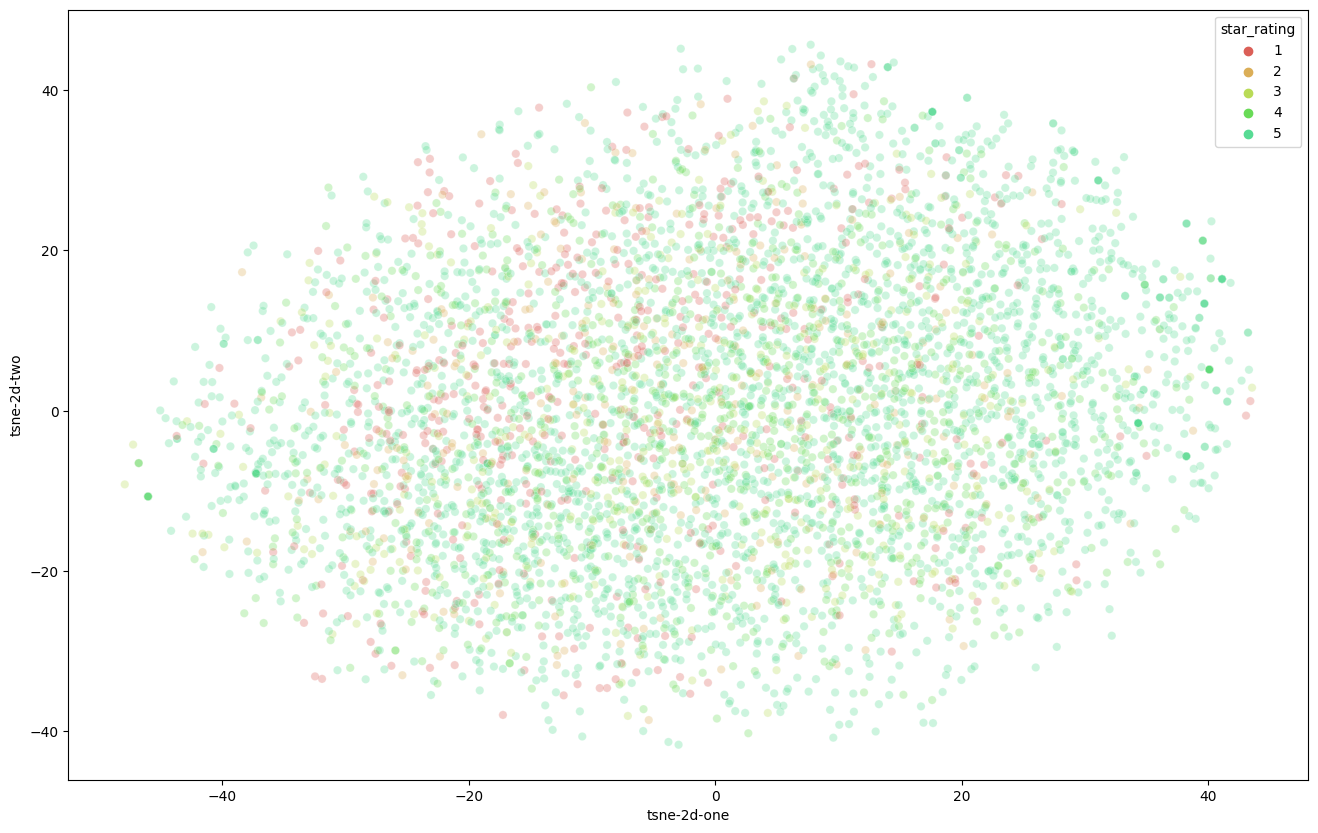

In [155]:
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="star_rating",
    palette=sns.color_palette("hls", 10),
    data=df_tsne_2_dim,
    legend="full",
    alpha=0.3
)

In [156]:
df_tsne_3_dim = pd.DataFrame([tsne_results[:,0].tolist(),
                              tsne_results[:,1].tolist(),
                              tsne_results[:,2].tolist()]).T
df_tsne_3_dim = df_tsne_3_dim.set_index(df.index)
df_tsne_3_dim.columns = ['tsne-3d-one', 'tsne-3d-two', 'tsne-3d-three']
df_tsne_3_dim['star_rating'] = df['star_rating']
df_tsne_3_dim

,tsne-3d-one,tsne-3d-two,tsne-3d-three,star_rating
1660627,-0.805901,16.147896,21.009211,5
1232608,-7.447353,-16.670254,14.748690,3
508804,23.515404,27.804110,-0.463379,5
1419576,-14.640969,-17.815041,-1.617636,5
567632,4.845508,12.611997,-2.874111,5
...,...,...,...,...
380606,-5.881214,37.897072,3.279467,5
73964,30.332502,10.073557,14.059322,5
1421630,5.373037,15.140000,11.160109,5
1646419,27.516062,7.945995,20.755558,3


In [157]:
import plotly.express as px
fig = px.scatter_3d(df_tsne_3_dim, x='tsne-3d-one', y='tsne-3d-two', z='tsne-3d-three', color='star_rating', width=1000, height=500)
fig.update_traces(marker_size = 3)
fig.show()